# Model Predictive Control

Optimal control is a method to use model predictions to plan an optimized future trajectory for time-varying systems. It is often referred to as Model Predictive Control (MPC) or Dynamic Optimization. A method to solve dynamic control problems is by numerically integrating the dynamic model at discrete time intervals, much like measuring a physical system at particular time points. The numerical solution is compared to a desired trajectory and the difference is minimized by adjustable parameters in the model that may change at every time step. The first control action is taken and then the entire process is repeated at the next time instance. The process is repeated because objective targets may change or updated measurements may have adjusted parameter or state estimates. Model predictive control has a number of manipulated variable (MV) and controlled variable (CV) tuning constants. The tuning constants are terms in the optimization objective function that can be adjusted to achieve a desired application performance.

As the tuning parameters are adjusted, the MPC profile is updated to reveal the effect of the change. Below is example MPC code in Python with Scipy.minimize.optimize instead of APMonitor. The shooting method used in this example is generally much slower than a simultaneous method and can only be used for stable systems.

<Figure size 720x432 with 0 Axes>

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.1944103240966797


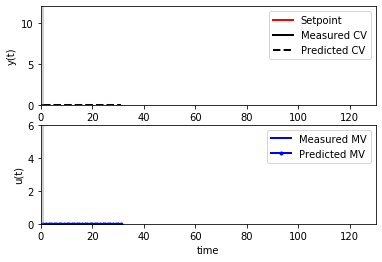

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.15603327751159668


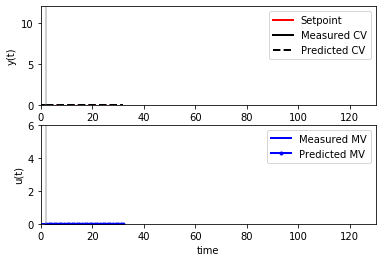

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.1690988540649414


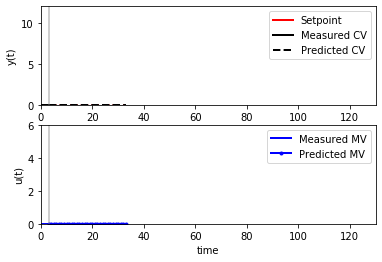

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.16702747344970703


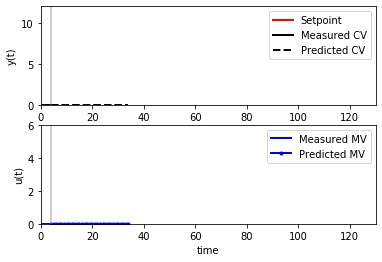

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.17495346069335938


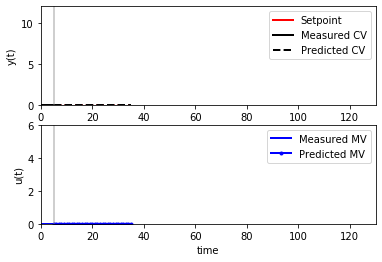

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.16793441772460938


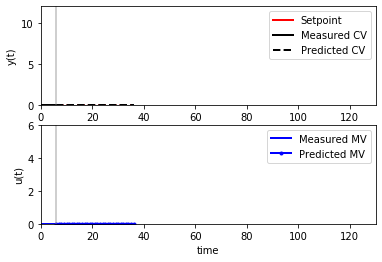

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.17000055313110352


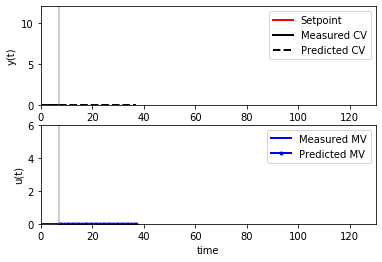

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.18201994895935059


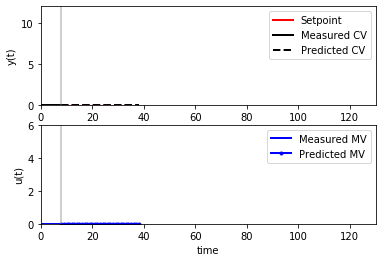

Initial SSE Objective: 0.0
Final SSE Objective: 0.0
Elapsed time: 0.22693490982055664


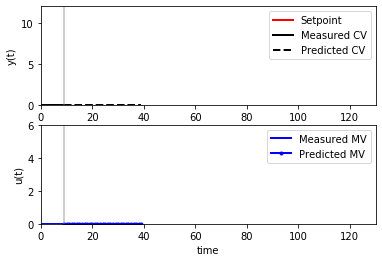

Initial SSE Objective: 750.0
Final SSE Objective: 105.66128568292498
Elapsed time: 3.5422780513763428


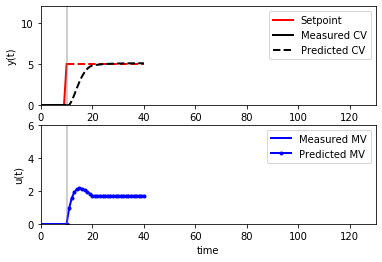

Initial SSE Objective: 213.56058558394818
Final SSE Objective: 62.6686160167463
Elapsed time: 3.197551727294922


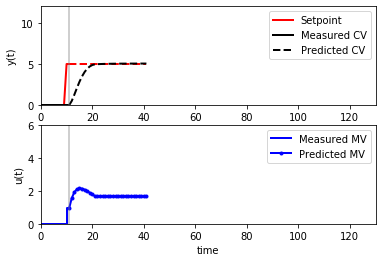

Initial SSE Objective: 51.167663171479816
Final SSE Objective: 34.89907609790071
Elapsed time: 2.850775718688965


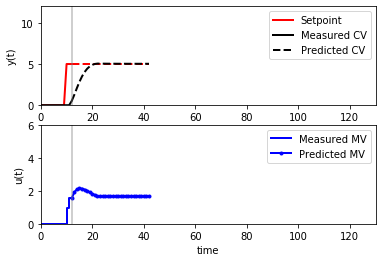

Initial SSE Objective: 27.3487525203967
Final SSE Objective: 18.268858032594384
Elapsed time: 3.3112411499023438


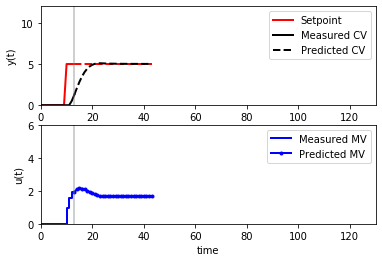

Initial SSE Objective: 36.77627689727675


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from scipy.optimize import minimize

# Make an MP4 animation?
make_mp4 = True
if make_mp4:
    import imageio  # required to make animation
    import os

# Define process model
def process_model(y,t,u,K,tau):
    # arguments
    #  y   = outputs
    #  t   = time
    #  u   = input value
    #  K   = process gain
    #  tau = process time constant

    # calculate derivative
    dydt = (-y + K * u)/(tau)

    return dydt

# Define Objective function      
def objective(u_hat):
    # Prediction
    for k in range(1,2*P+1):
        if k==1:
            y_hat0 = yp[i-P]

        if k<=P:
            if i-P+k<0:
                u_hat[k] = 0

            else:
                u_hat[k] = u[i-P+k]

        elif k>P+M:
            u_hat[k] = u_hat[P+M]

        ts_hat = [delta_t_hat*(k-1),delta_t_hat*(k)]        
        y_hat = odeint(process_model,y_hat0,ts_hat,args=(u_hat[k],K,tau))
        y_hat0 = y_hat[-1]
        yp_hat[k] = y_hat[0]

        # Squared Error calculation
        sp_hat[k] = sp[i]
        delta_u_hat = np.zeros(2*P+1)        

        if k>P:
            delta_u_hat[k] = u_hat[k]-u_hat[k-1]
            se[k] = (sp_hat[k]-yp_hat[k])**2 + 20 * (delta_u_hat[k])**2

    # Sum of Squared Error calculation      
    obj = np.sum(se[P+1:])
    return obj

# FOPDT Parameters
K=3.0      # gain
tau=5.0    # time constant
ns = 100    # Simulation Length
t = np.linspace(0,ns,ns+1)
delta_t = t[1]-t[0]

# Define horizons
P = 30 # Prediction Horizon
M = 10  # Control Horizon

# Input Sequence
u = np.zeros(ns+1)

# Setpoint Sequence
sp = np.zeros(ns+1+2*P)
sp[10:40] = 5
sp[40:80] = 10
sp[80:] = 3
# Controller setting
maxmove = 1

## Process simulation
yp = np.zeros(ns+1)

#  Create plot
plt.figure(figsize=(10,6))
plt.ion()
plt.show()

for i in range(1,ns+1):
    if i==1:
        y0 = 0
    ts = [delta_t*(i-1),delta_t*i]
    y = odeint(process_model,y0,ts,args=(u[i],K,tau))
    y0 = y[-1]
    yp[i] = y[0]

    # Declare the variables in fuctions
    t_hat = np.linspace(i-P,i+P,2*P+1)
    delta_t_hat = t_hat[1]-t_hat[0]
    se = np.zeros(2*P+1)
    yp_hat = np.zeros(2*P+1)
    u_hat0 = np.zeros(2*P+1)
    sp_hat = np.zeros(2*P+1)
    obj = 0.0

    # initial guesses
    for k in range(1,2*P+1):

        if k<=P:
            if i-P+k<0:
                u_hat0[k] = 0

            else:
                u_hat0[k] = u[i-P+k]

        elif k>P:
            u_hat0[k] = u[i]

    # show initial objective
    print('Initial SSE Objective: ' + str(objective(u_hat0)))

    # MPC calculation
    start = time.time()

    solution = minimize(objective,u_hat0,method='SLSQP')
    u_hat = solution.x  

    end = time.time()
    elapsed = end - start

    print('Final SSE Objective: ' + str(objective(u_hat)))
    print('Elapsed time: ' + str(elapsed) )

    delta = np.diff(u_hat)

    if i<ns:    
        if np.abs(delta[P]) >= maxmove:
            if delta[P] > 0:
                u[i+1] = u[i]+maxmove
            else:
                u[i+1] = u[i]-maxmove

        else:
            u[i+1] = u[i]+delta[P]

    # plotting for forced prediction
    plt.clf()
    plt.subplot(2,1,1)
    plt.plot(t[0:i+1],sp[0:i+1],'r-',linewidth=2,label='Setpoint')
    plt.plot(t_hat[P:],sp_hat[P:],'r--',linewidth=2)
    plt.plot(t[0:i+1],yp[0:i+1],'k-',linewidth=2,label='Measured CV')
    plt.plot(t_hat[P:],yp_hat[P:],'k--',linewidth=2,label='Predicted CV')
    plt.axvline(x=i,color='gray',alpha=0.5)
    plt.axis([0, ns+P, 0, 12])
    plt.ylabel('y(t)')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t[0:i+1],u[0:i+1],'b-',linewidth=2,label='Measured MV')
    plt.plot(t_hat[P:],u_hat[P:],'b.-',linewidth=2,label='Predicted MV')
    plt.axvline(x=i,color='gray',alpha=0.5)
    plt.ylabel('u(t)')
    plt.xlabel('time')
    plt.axis([0, ns+P, 0, 6])
    plt.legend()
    plt.draw()
    plt.pause(0.1)
    if make_mp4:
        filename='pictures/plot_'+str(i+10000)+'.png'
        plt.savefig(filename)

# generate mp4 from png figures in batches of 350
if make_mp4:
    images = []
    iset = 0
    for i in range(1,ns):
        filename='pictures/plot_'+str(i+10000)+'.png'
        images.append(imageio.imread(filename))
        if ((i+1)%350)==0:
            imageio.mimsave('results_'+str(iset)+'.mp4', images)
            iset += 1
            images = []
    if images!=[]:
        imageio.mimsave('results_'+str(iset)+'.mp4', images)